# Object Tracking

---
### Imports and Helper-functions

In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(img, title=None, size=10, axis=False, color_space="BGR"):
    aspect_ratio = img.shape[0] / img.shape[1]
    plt.figure(figsize=(size * aspect_ratio, size))
    if color_space.lower() == "bgr":
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_space.lower() == "rgb":
        rgb_img = img
    else:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(rgb_img)
    if type(title) == str:
        plt.title(title)
    if axis == False:
        plt.axis('off')
    plt.show()

In [3]:
def get_random_img_path(search_path='../../res/img', skip=["flickr"]):
    """
    This function searches for common image files in all subdirectories
    and return a random image path of them.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.ico']
    image_paths = []

    # Walk through all subdirectories
    for root, dirs, files in os.walk(search_path):
        for file_name in files:
            # Check if the file is an image
            if any(file_name.lower().endswith(ext) for ext in image_extensions):
                # Get the full file path
                full_path = os.path.join(root, file_name).replace("\\", "/")
                if not any(i in full_path for i in skip):
                    image_paths.append(full_path)

    return random.choice(image_paths)

---
### Lucas-Kanade Optical Flow Algorithm

Optical flow is the pattern of apparent motion of image objects between two consecutive frames caused by the movemement of object or camera. It is 2D vector field where each vector is a displacement vector showing the movement of points from first frame to second. Consider the image below (Image Courtesy: Wikipedia article on Optical Flow).


![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Optical_flow_example_v2.png/440px-Optical_flow_example_v2.png)

It shows a ball moving in 5 consecutive frames. The arrow shows its displacement vector. Optical flow has many applications in areas like :

- Structure from Motion
- Video Compression
- Video Stabilization

Optical flow works on several assumptions:

- The pixel intensities of an object do not change between consecutive frames.
- Neighbouring pixels have similar motion.

Learn more - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html

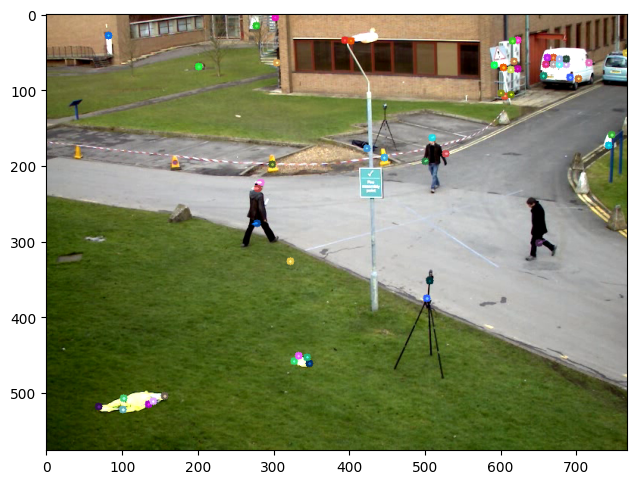

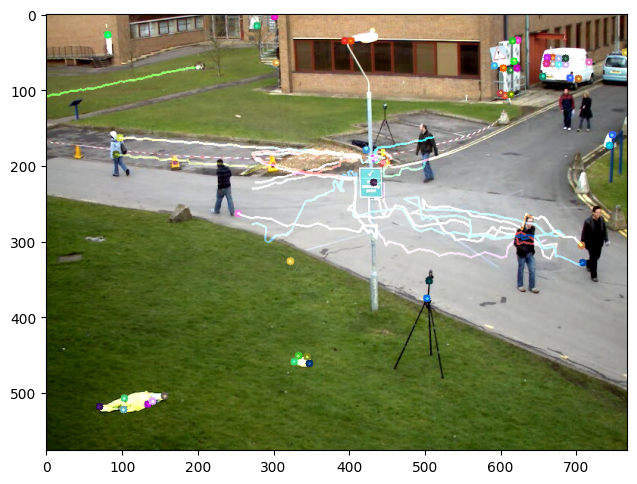

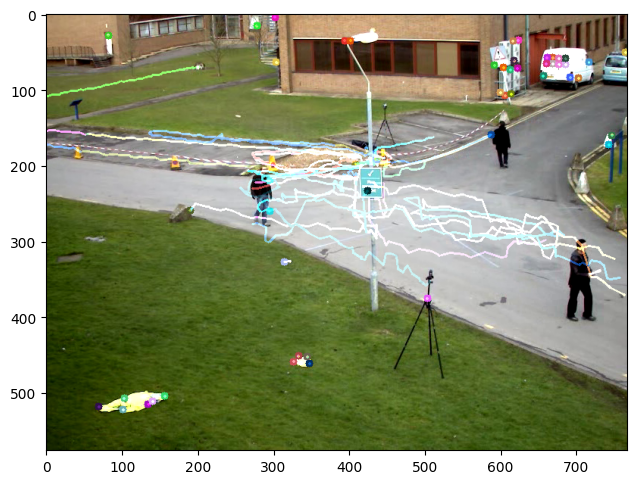

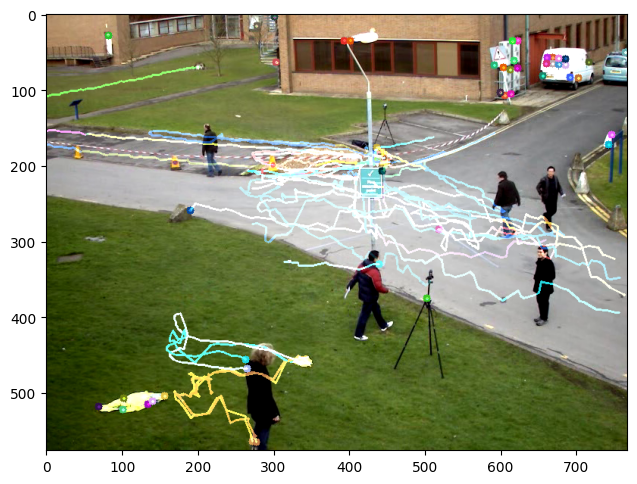

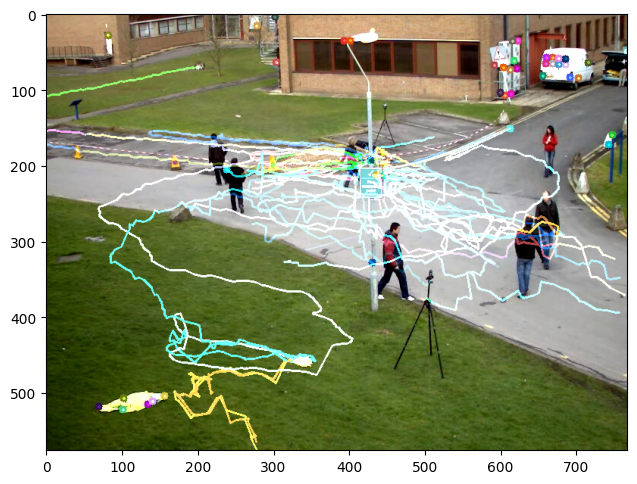

In [10]:
cap = cv2.VideoCapture('../../res/img/course_img/walking.avi')

ret, frame = cap.read()

width = int(cap.get(3))
height = int(cap.get(4))

out = cv2.VideoWriter('../../res/img/course_img/walking_optical_flow.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 30, (width, height))

# Set parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Set parameters for lucas kanade optical flow
lucas_kanade_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
# Used to create our trails for object movement in the image 
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Find inital corner locations
prev_corners = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(prev_frame)

output_images = []

while True:
    ret, frame = cap.read()

    if ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        new_corners, status, errors = cv2.calcOpticalFlowPyrLK(prev_gray, 
                                                                frame_gray, 
                                                                prev_corners, 
                                                                None, 
                                                                **lucas_kanade_params)

        # Select and store good points
        good_new = new_corners[status==1]
        good_old = prev_corners[status==1]

        # Draw the tracks
        for i,(new,old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            a = int(a)
            b = int(b)
            c = int(c)
            d = int(d)
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a,b), 5, color[i].tolist(),-1)
            
        img_out = cv2.add(frame,mask)
        out.write(img_out)
        output_images += [img_out]

        # Now update the previous frame and previous points
        prev_gray = frame_gray.copy()
        prev_corners = good_new.reshape(-1,1,2)
    else:
        break

cap.release()
out.release()

step_size = len(output_images)//4
for cur_img in output_images[::step_size]:
    imshow(cur_img, axis=True)

---
### Dense Optical Flow

Lucas-Kanade method computes optical flow for a sparse feature set (in our example, corners detected using Shi-Tomasi algorithm). OpenCV provides another algorithm to find the dense optical flow. It computes the optical flow for all the points in the frame. It is based on Gunner Farneback’s algorithm which is explained in “[Two-Frame Motion Estimation Based on Polynomial Expansion](https://www.researchgate.net/publication/225138825_Two-Frame_Motion_Estimation_Based_on_Polynomial_Expansion)” by Gunner Farneback in 2003.

Below sample shows how to find the dense optical flow using above algorithm. We get a 2-channel array with optical flow vectors, (u,v). We find their magnitude and direction. We color code the result for better visualization. 

- Direction corresponds to Hue value of the image. 
- Magnitude corresponds to Value plane. See the code below:

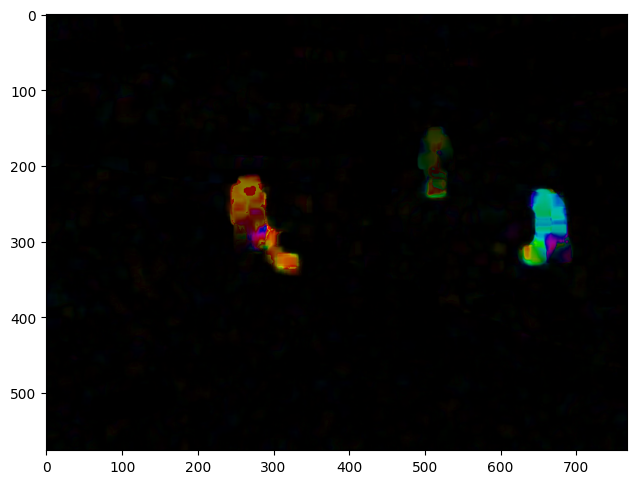

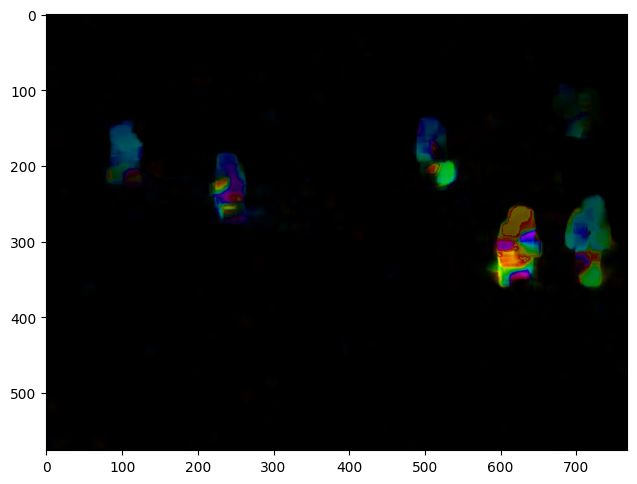

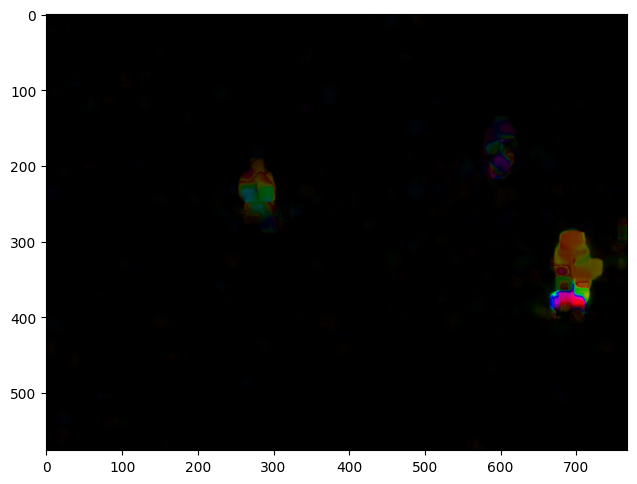

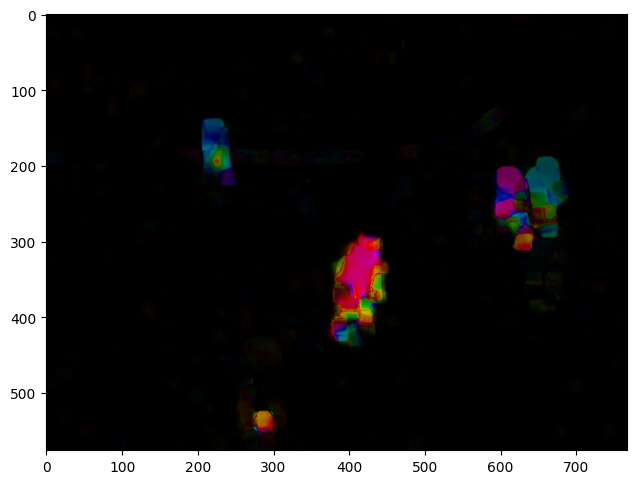

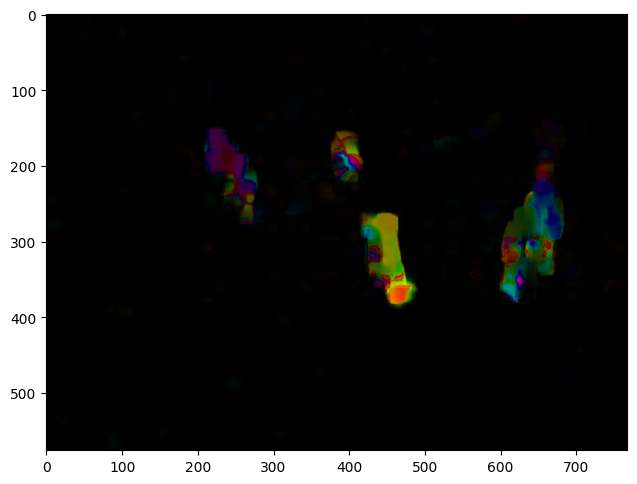

In [12]:
# Load video stream
cap = cv2.VideoCapture('../../res/img/course_img/walking.avi')

# Get the height and width of the frame (required to be an interger)
width = int(cap.get(3)) 
height = int(cap.get(4))

# Define the codec and create VideoWriter object. The output is stored in '*.avi' file.
out = cv2.VideoWriter('../../res/img/course_img/dense_optical_flow_walking.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width, height))

# Get first frame
ret, first_frame = cap.read()
previous_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(first_frame)
hsv[...,1] = 255

output_images = []

while True:
    
    # Read of video file
    ret, frame2 = cap.read()

    if ret == True:
      next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

      # Computes the dense optical flow using the Gunnar Farneback’s algorithm
      flow = cv2.calcOpticalFlowFarneback(previous_gray, next, 
                                          None, 0.5, 3, 15, 3, 5, 1.2, 0)

      # use flow to calculate the magnitude (speed) and angle of motion
      # use these values to calculate the color to reflect speed and angle
      magnitude, angle = cv2.cartToPolar(flow[...,0], flow[...,1])
      hsv[...,0] = angle * (180 / (np.pi/2))
      hsv[...,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
      final = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

      # Save Video
      out.write(final)
      # Show our demo of Dense Optical Flow
      #imshow('Dense Optical Flow', final)

      output_images += [final]
      
      # Store current image as previous image
      previous_gray = next

    else:
      break
    
cap.release()
out.release()

step_size = len(output_images)//4
for cur_img in output_images[::step_size]:
    imshow(cur_img, axis=True)

---